# Exploratory Data Analysis of Book-Crossing Dataset : Users

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import collections

random.seed(42)
np.random.seed(42)

## Download Data

In [66]:
dataset_path = '/opt/ml/data/'

users = pd.read_csv(dataset_path+'users.csv')
print('users shape: ', users.shape)

users shape:  (68092, 3)


In [67]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [68]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [6]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,68092.0,139381.329539,80523.969862,8.0,69008.75,138845.5,209388.25,278854.0
age,40259.0,36.069873,13.842571,5.0,25.00,34.0,45.00,99.0


In [7]:
# 고유값 개수
users['user_id'].nunique()

68092

In [8]:
# 결측치 비율
users.isna().sum()/len(users)

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

## Preprocessing & Feature Engineering

## 1. age

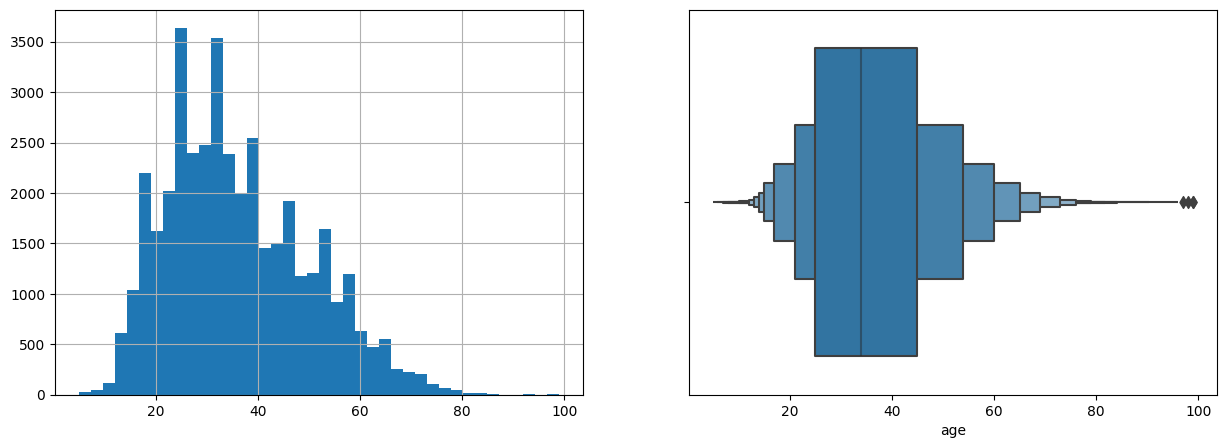

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

users['age'].hist(bins=40, ax=ax[0])
sns.boxenplot(data=users, x='age',ax=ax[1])
plt.show();

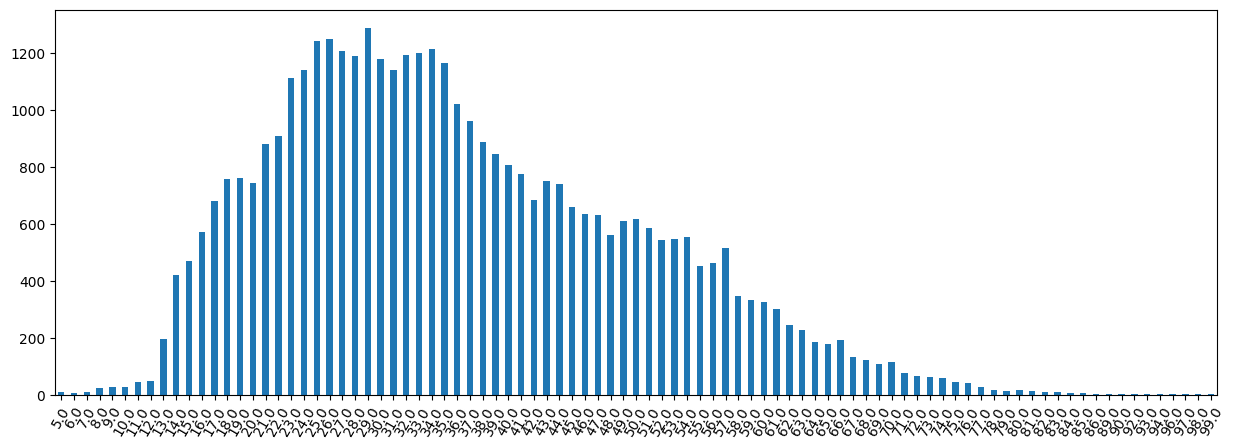

In [10]:
plt.figure(figsize=(15, 5))
users['age'].value_counts().sort_index().plot(kind='bar', rot=60)
plt.show();

### Missing Value Imputation

In [71]:
users_copy = users.copy()

1. random choice를 통해 결측치 대체

In [72]:
users_age_dropna = users.dropna(subset=['age']) # age 결측치를 모두 drop한 users
users_age_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40259 entries, 1 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40259 non-null  int64  
 1   location  40259 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


In [73]:
size = users.age.isna().sum()
random_ages = np.random.choice(users_age_dropna['age'], size=size)
random_ages = pd.DataFrame(random_ages)
random_ages.head()

,0
0,30.0
1,30.0
2,23.0
3,41.0
4,56.0


In [75]:
# 샘플링으로 채워 넣기
age_nan = users.age.isna()
to_fill = np.random.choice(users_age_dropna['age'], size=size)
users.loc[age_nan, 'age'] = to_fill

In [76]:
users.isna().sum()

user_id     0
location    0
age         0
dtype: int64

2. 정규분포에서 샘플을 생성해 결측치 대체


https://github.com/PascPeli/Book-Crossing-Data-Cleansing-for-Recommendations/blob/master/BookCrossing%20data%20cleansing.ipynb

In [77]:
users_copy.isna().sum()

user_id         0
location        0
age         27833
dtype: int64

In [78]:
# 정규분포 생성
loc = users_copy.age.mean() # 평균
scale = users_copy.age.std() # 표준편차
size = users_copy.age.isna().sum()
temp_age_series = pd.Series(np.random.normal(loc=loc, scale=scale, size=size))
print("Statistics of values in \'users.age\'\n",users.age.describe(),"\n")
print("Statistics of values we are going to use to fill NaN \n",temp_age_series.describe(),"\n")
print("Negative values in \'temp_age_seires\':", temp_age_series[temp_age_series<0].count())

Statistics of values in 'users.age'
 count    68092.000000
mean        36.036979
std         13.798546
min          5.000000
25%         25.000000
50%         34.000000
75%         45.000000
max         99.000000
Name: age, dtype: float64 

Statistics of values we are going to use to fill NaN 
 count    27833.000000
mean        36.168450
std         13.870574
min        -23.389384
25%         26.776490
50%         36.221562
75%         45.603308
max         87.915552
dtype: float64 

Negative values in 'temp_age_seires': 136


In [79]:
# abs를 통해 음수값 양수로 변경
pos_age_series=np.abs(temp_age_series)

In [80]:
# sort users Df so as NaN values in age to be first and reset index to match with index of pos_age_series. Then use fillna()
users_copy = users_copy.sort_values('age', na_position='first').reset_index(drop=True)
users_copy.age.fillna(pos_age_series, inplace = True)

In [81]:
# replace values < 5 or > 99 with the mean(). Round values and convert them to int. 
# 위에서 시각화 그림을 보면, 5 이상 99 이하 age 값이 있다는 것을 알 수 있음.
users_copy.loc[users_copy.age<5, 'age'] = users_copy.age.mean()
users_copy.loc[users_copy.age>99, 'age'] = users_copy.age.mean()
users_copy.age = users_copy.age.round().astype(int)

In [82]:
#Sort users based on user_id so as to be the same as before
users_copy = users_copy.sort_values('user_id').reset_index(drop=True)
print(users_copy.isna().sum())
users_copy.head()

user_id     0
location    0
age         0
dtype: int64


,user_id,location,age
0,8,"timmins, ontario, canada",23
1,9,"germantown, tennessee, usa",52
2,12,"fort bragg, california, usa",43
3,14,"mediapolis, iowa, usa",19
4,16,"albuquerque, new mexico, usa",28


### Convert Numerical Value to Categorical Value

In [85]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    else: 
        return 6

In [86]:
users['age'] = users[users['age'].notnull()]['age'].apply(age_map)

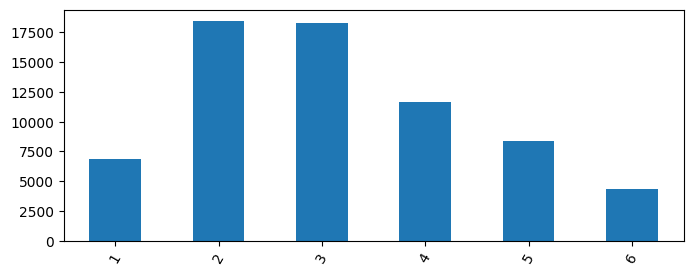

In [89]:
plt.figure(figsize=(8, 3))
users['age'].value_counts().sort_index().plot(kind='bar', rot=60)
plt.show();

In [90]:
users.age.value_counts(normalize=True)

2    0.271706
3    0.269121
4    0.171503
5    0.122995
1    0.100966
6    0.063708
Name: age, dtype: float64

## 2. location

### Split location into city, state, country

In [94]:
# 특수문자 제거 
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '', regex=True) 

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

In [95]:
#특수문자 제거로 n/a가 na로 바뀌게 되었음. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환해줌.
users = users.replace('na', np.nan)
 # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환해줌.
users = users.replace('', np.nan)

### Missing Value Imputation

In [96]:
users.isna().sum()

user_id                0
location               0
age                    0
location_city        122
location_state      3254
location_country    2124
dtype: int64

In [99]:
users[users['location_country'].isna() & users['location_city'].notna()]

,user_id,location,age,location_city,location_state,location_country
6,116866,"ottawa,,",3,ottawa,NaN,NaN
32,115097,"seattle,,",2,seattle,NaN,NaN
49,245827,"albuquerque,,",2,albuquerque,NaN,NaN
72,226745,"humble,,",3,humble,NaN,NaN
120,38718,"aloha,,",1,aloha,NaN,NaN
...,...,...,...,...,...,...
67797,257311,"lisbon,maine,",3,lisbon,maine,NaN
67929,267240,"houston,,",2,houston,NaN,NaN
67930,267276,"sammamish,,",1,sammamish,NaN,NaN
68058,276221,"calgary,,",3,calgary,NaN,NaN


In [100]:
users[users['location_state'].isna() & users['location_city'].notna()]

,user_id,location,age,location_city,location_state,location_country
6,116866,"ottawa,,",3,ottawa,NaN,NaN
32,115097,"seattle,,",2,seattle,NaN,NaN
49,245827,"albuquerque,,",2,albuquerque,NaN,NaN
72,226745,"humble,,",3,humble,NaN,NaN
120,38718,"aloha,,",1,aloha,NaN,NaN
...,...,...,...,...,...,...
68058,276221,"calgary,,",3,calgary,NaN,NaN
68061,276618,"stuttgart,na,germany",3,stuttgart,NaN,germany
68063,276660,"singapore,na,singapore",1,singapore,NaN,singapore
68064,276729,"rijeka,na,croatia",1,rijeka,NaN,croatia


In [101]:
# country는 없고, city는 있는 경우 처리
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

location_list[:10]

['ottawa,ontario,canada',
 'seattle,washington,usa',
 'albuquerque,newmexico,usa',
 'humble,texas,usa',
 'aloha,oregon,usa',
 'pearland,texas,usa',
 'sarasota,florida,usa',
 'westspringfield,massachusetts,usa',
 'westlinn,oregon,usa',
 'northfortmyers,florida,usa']

In [102]:
for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

In [104]:
# state는 없는데, city는 있는 경우 처리
modify_location = users[(users['location_state'].isna())&(users['location_city'].notnull())]['location_city'].values

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_state'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

location_list[:10]

['mtairy,maryland,usa',
 'brussels,brussels,belgium',
 'quezoncity,metromanila,philippines',
 'portoalegre,riograndedosul,brazil',
 'nacogdoches,texas,usa',
 'belgrade,montana,usa',
 'istanbul,istanbul,turkey',
 'hobart,tasmania,australia',
 'pasigcity,metromanila,philippines',
 'valladolid,valladolid,spain']

In [105]:
for location in location_list:
  users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
  users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

In [106]:
users.isna().sum()

user_id               0
location              0
age                   0
location_city       122
location_state      606
location_country    266
dtype: int64

<class 'dict'>
<class 'dict_items'>


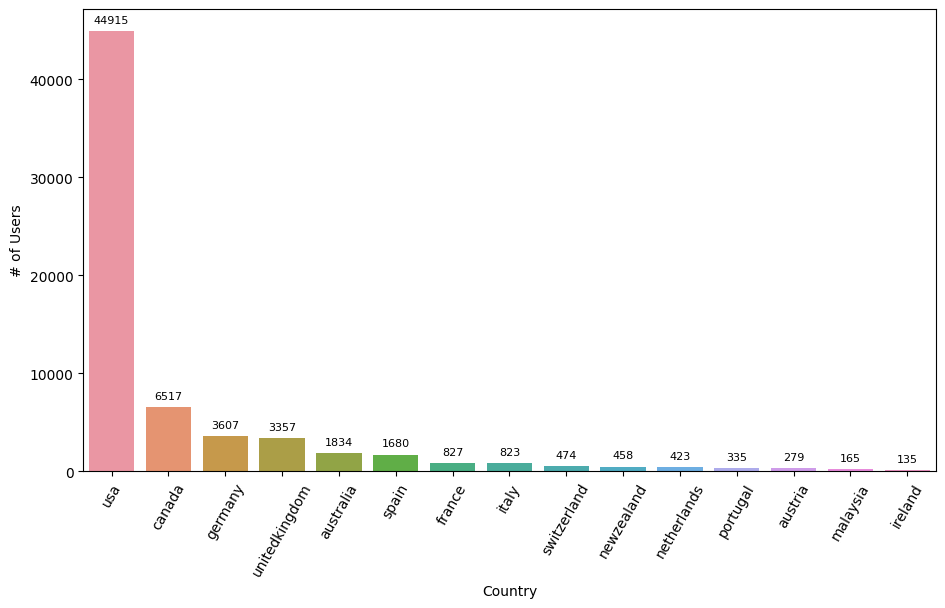

In [112]:
my_dict=(users['location_country'].value_counts()).to_dict()
print(type(my_dict))
print(type(my_dict.items()))
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show();

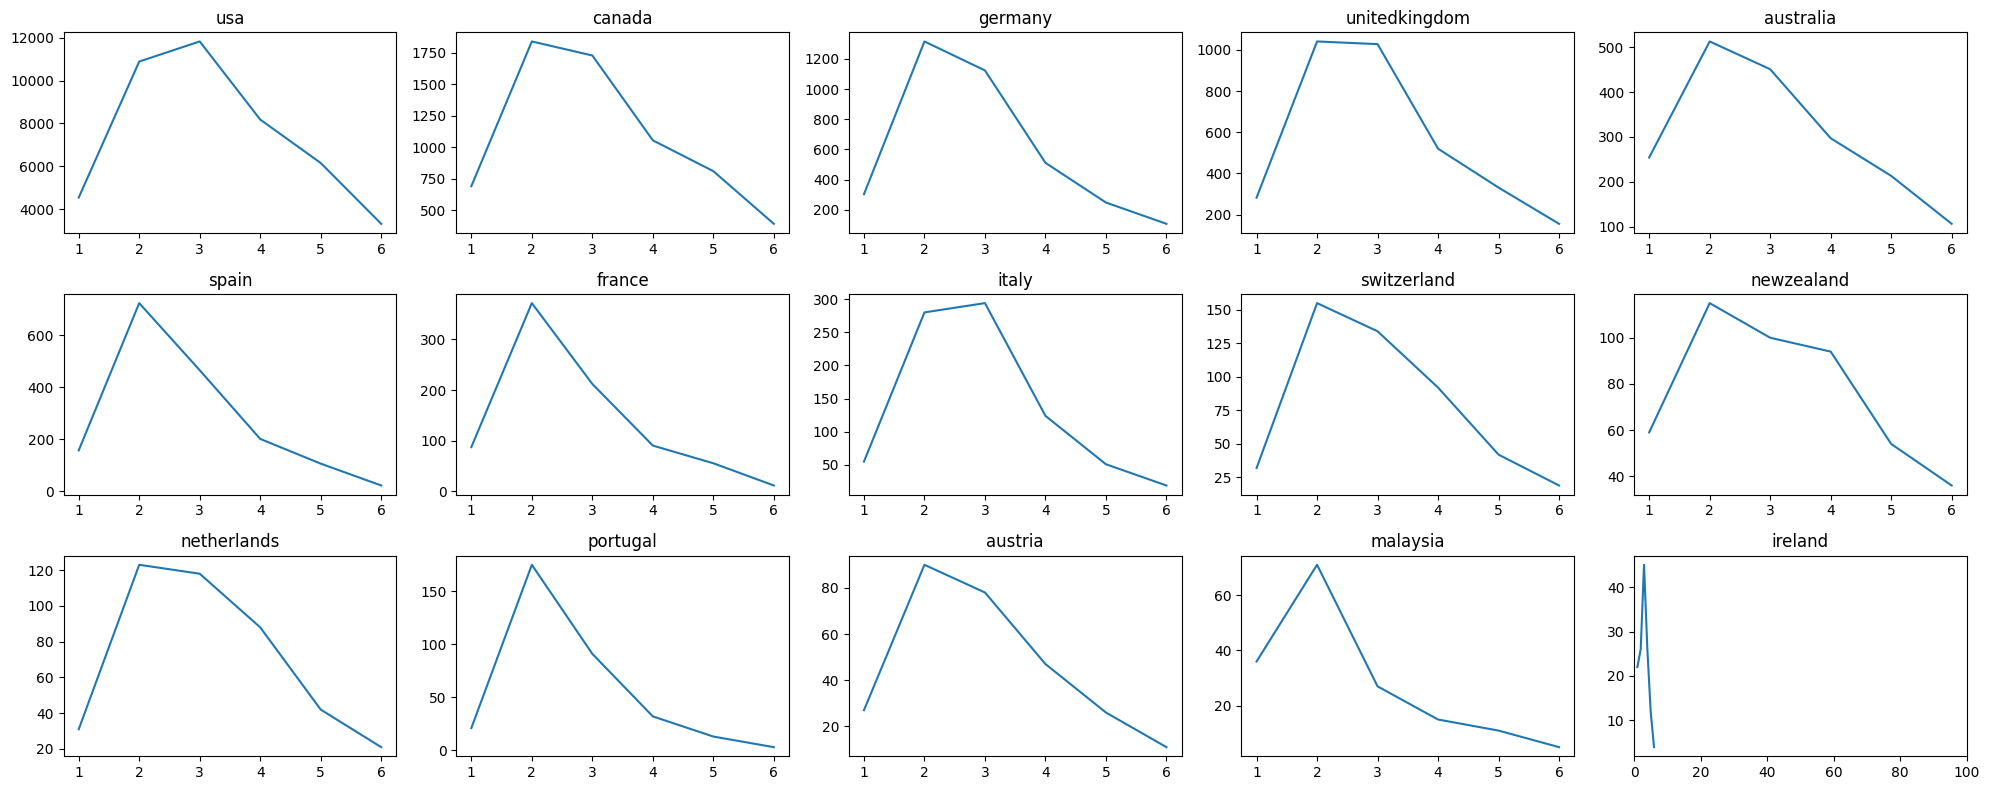

In [113]:
fig, ax = plt.subplots(3,5,figsize=(20,8))
for country, ax_ in zip(f['location_country'], ax.flatten()):
    users[(users['location_country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

## Final Data

In [ ]:
version = 'v1'
users.to_csv(dataset_path + f"users_{version}.csv", index=False)